# Predictive Maintenance using LSTM (CMAPSS FD001)

This notebook implements a supervised time-series regression model for Remaining Useful Life (RUL) prediction using the NASA CMAPSS dataset.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# Set random seeds for reproducibility

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Load the training data

train = pd.read_csv("../data/train_FD001.txt", sep="\s+", header=None)
train = train.dropna(axis=1, how='all')

# Assign column names

train.columns = ['unit', 'cycle'] + [f'op{i}' for i in range(1,4)] + \
        [f'sensor{i}' for i in range(1,22)]

In [ ]:
# Calculate RUL for each row

max_cycle = train.groupby('unit')['cycle'].max()
train['RUL'] = train.apply(lambda row: max_cycle[row['unit']] - row['cycle'], axis=1)

# RUL clipping

train['RUL'] = train['RUL'].clip(upper=125)

In [ ]:
# Prepare features and target variable

features = train.drop(columns=['unit', 'cycle', 'RUL'])
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)
y = train['RUL'].values

In [ ]:
# Create sequences for LSTM input

sequence_length = 30
X_seq = []
y_seq = []

for i in range(len(X_scaled) - sequence_length):
    X_seq.append(X_scaled[i:i+sequence_length])
    y_seq.append(y[i+sequence_length])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

X_seq.shape

(20601, 30, 24)

In [ ]:
# Split into training and validation sets

split = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]

In [ ]:
# Build the LSTM model

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=False, input_shape=(30, X_seq.shape[2])),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

c:\Users\HEMANTH\anaconda3\envs\pm_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,897 (97.25 KB)

 Trainable params: 24,897 (97.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model with early stopping

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 3248.0369 - root_mean_squared_error: 56.9916 - val_loss: 1736.0403 - val_root_mean_squared_error: 41.6658
Epoch 2/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1777.3406 - root_mean_squared_error: 42.1585 - val_loss: 1715.5153 - val_root_mean_squared_error: 41.4188
Epoch 3/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 1372.0842 - root_mean_squared_error: 37.0417 - val_loss: 716.4711 - val_root_mean_squared_error: 26.7670
Epoch 4/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 450.6838 - root_mean_squared_error: 21.2293 - val_loss: 301.7378 - val_root_mean_squared_error: 17.3706
Epoch 5/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 385.3406 - root_mean_squared_error: 19.6301 - val_loss: 323.3295 - val_root_mean_squared_error: 17.9814
Epoch 6/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 352.2616 - root_mean_squared_error: 18.7686 - val_loss: 334.4448 - val_root_mean_squared_error: 18.2878
Epoch

In [ ]:
# Evaluate on validation set

predictions = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, predictions))
print("Validation RMSE:", rmse)

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Validation RMSE: 17.081131321578617


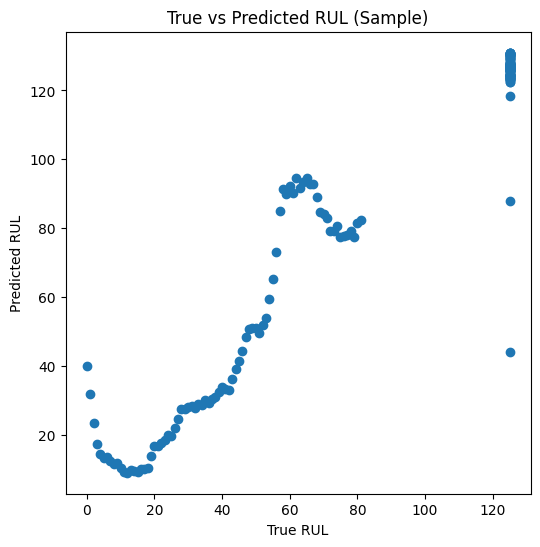

In [ ]:
# Plot true vs predicted RUL for a sample of validation data

plt.figure(figsize=(6,6))
plt.scatter(y_val[:200], predictions[:200])
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("True vs Predicted RUL (Sample)")
plt.show()